In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torchaudio
import librosa

import sys
import os
from os.path import join as opj
from os.path import join, exists, split
from data.audioLDM_pre import *

import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')

# from glmsingle.glmsingle import GLM_single
import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix

default_n_threads = 64
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


In [2]:
base_data_path="/data01/data/fMRI_music_genre/ds003720-download/derivatives"  # -download
base_event_path="/data01/data/fMRI_music_genre/ds003720-download"

subj="sub-001"

data_path=opj(base_data_path,subj,"func")
# event_path=opj(base_data_path,"events")

stim_dir="/data01/data/fMRI_music_genre/data_wav/genres_original"


sessions=os.listdir(data_path)

# training_stimuli= pd.read_csv(opj(base_data_path,"stimulus_ImageNetTraining.tsv"),sep="\t",names=["stimulus_id","category","label","idx"],header=None,dtype={"stimulus_id":str,"category":str,"label":int,"idx":int})
# test_stimuli= pd.read_csv(opj(base_data_path,"stimulus_ImageNetTest.tsv"),sep="\t",names=["stimulus_id","category","label","idx"],header=None,dtype={"stimulus_id":str,"category":str,"label":int,"idx":int})

In [3]:
filenames=glob.glob(opj(data_path,"*-preproc_bold.nii.gz"))

In [4]:
data=[]
events=[]
drop_first=0



for fn in tqdm.tqdm(filenames):
    #load file
    print(data_path,fn)
    
    name=fn.split("/")[-1].replace("_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz","_events.tsv")
    
    events_path=opj(base_event_path,subj,"func",name)
    # print(opj(data_path_ses,fn),opj(event_path,fn.replace('_bold_preproc.nii.gz','_events.tsv')))

    x=nib.load(fn)
    # df=pd.read_csv(fn.replace('_bold.nii','_events.tsv'),sep='\t',)
    df=pd.read_csv(events_path,sep='\t',)
    
    events.append(df)
    data.append(x)

100%|██████████| 18/18 [00:00<00:00, 597.66it/s]

/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func/sub-001_task-Test_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data01/data/fMRI_music_genre/ds003720-download/derivatives/sub-001/func /data01/data/fMRI_music_genre/ds003720-

In [5]:
masker = maskers.NiftiMasker(mask_strategy="epi")
masker.fit(data[0])
report = masker.generate_report()

In [6]:
mask=False
tgt_dir=f"/data01/data/fMRI_music_genre/fmri_preproc_data/{subj}"

if mask:
    for i in tqdm.trange(len(data)):
        data[i]=masker.transform_single_imgs(data[i]).T
    
    os.makedirs(tgt_dir,exist_ok=True)

    for i in range(len(data)):
        print(data[i].shape)
        print(f"{tgt_dir}/{filenames[i].split('/')[-1].replace('.nii.gz','.npy')}")
        np.save(f"{tgt_dir}/{filenames[i].split('/')[-1].replace('.nii.gz','.npy')}",data[i])
else:
    for i,f in enumerate(filenames):
        data[i]=np.load(f"{tgt_dir}/{f.split('/')[-1].replace('.nii.gz','.npy')}")

In [7]:
len(data)

18

In [8]:
data[1].shape

(237653, 410)

In [9]:
for e in events:
    # e["category"]=e["genre"]+e["track"]
    e['category'] = e.apply(lambda row: f"{row['genre']}_{row['track']}", axis=1)    
    e["trial_type"]=e["category"]


In [10]:
TR=1.5
cleaned_data=[nilearn.signal.clean(d.T,detrend=True,standardize=True,t_r=TR) for d in data] # detrend and standardize
# nii_cleaned_data=[masker.inverse_transform(i) for i in cleaned_data]


In [11]:
cleaned_data[1].shape

(410, 237653)

## Prepare dataset

1) Save fMRI activity of each stim and related audio for all runs
2) Encode all audio
3) Clustering
4) Average fMRI activity
5) Can we predict music cluster from fMRI?

In [12]:
train_fmri=[]
test_fmri=[]
train_audio=[]
test_audio=[]
train_sr=[]
test_sr=[]

train_genre=[]
test_genre=[]

train_filename=[]
test_filename=[]

TR=1.5
stimdur=10
how_many_fmri_vols=10
fmri_vol_delay=3

for run_data, run_event, fn in zip(cleaned_data, events, filenames):
    
    for i in tqdm.trange(len(run_event)):
        start_vol=(run_event.iloc[i].onset//TR).astype(np.int64) + fmri_vol_delay

        tmp_fmri_data=run_data[start_vol:start_vol+how_many_fmri_vols]
        tmp_stim=opj(stim_dir,run_event.iloc[i].genre.replace("'",""),run_event.iloc[i].genre.replace("'","")+"."+f"{run_event.iloc[i].track}".zfill(5)+".wav")
        audio, _, _, _, _ = read_audio_file(tmp_stim)  # --> AudioLDM features
        
        if "task-Test" in fn:
            test_fmri.append(tmp_fmri_data)
            test_audio.append(audio.T)
            test_sr.append(sampling_rate)
            test_genre.append(run_event.iloc[i].genre.replace("'",""))
            test_filename.append(run_event.iloc[i].genre.replace("'","")+"."+f"{run_event.iloc[i].track}".zfill(5))

        elif "task-Training" in fn:
            train_fmri.append(tmp_fmri_data)
            train_audio.append(audio.T)
            train_sr.append(sampling_rate)
            train_genre.append(run_event.iloc[i].genre.replace("'",""))
            train_filename.append(run_event.iloc[i].genre.replace("'","")+"."+f"{run_event.iloc[i].track}".zfill(5))


train_fmri_avg=[]
test_fmri_avg=[]
for f in tqdm.tqdm(train_fmri):
    train_fmri_avg.append(f.mean(0))
for f in tqdm.tqdm(test_fmri):
    test_fmri_avg.append(f.mean(0))
train_fmri_avg=torch.tensor(train_fmri_avg)
test_fmri_avg=torch.tensor(test_fmri_avg)






100%|██████████| 246/246 [00:00<00:00, 1433.93it/s]


In [13]:
train_genre=np.array(train_genre)
test_genre=np.array(test_genre)


In [14]:
print(train_fmri[0].shape)
print(test_fmri[0].shape)
print(train_audio[0].shape)
print(test_audio[0].shape)
print(train_sr[0])
print(train_genre.shape)
print(test_genre.shape)

(10, 237653)
(10, 237653)
torch.Size([64, 3000])
torch.Size([64, 3000])
16000
(492,)
(246,)


In [15]:
from diffusers import AudioLDM2Pipeline
repo_id = "cvssp/audioldm2-music"
pipe = AudioLDM2Pipeline.from_pretrained(repo_id)
vae = pipe.vae
unet = pipe.unet
encoder = vae.encode
decoder = vae.decoder
decoding = vae.decode
vocoder = pipe.vocoder
mel_spect_to_wav = pipe.mel_spectrogram_to_waveform

Loading pipeline components...: 100%|██████████| 11/11 [00:01<00:00,  5.66it/s]


In [16]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)
# encoder = encoder.to(device)

In [17]:
train_audio_feat=[]
test_audio_feat=[]


# -----> audioLDM
with torch.no_grad():
    for wv,sr in tqdm.tqdm(zip(train_audio,train_sr)):
        inputs = encoder(wv.unsqueeze(0).unsqueeze(0).to(device))
        inputs = inputs.latent_dist.sample()
        train_audio_feat.append(inputs)

with torch.no_grad():
    for wv,sr in tqdm.tqdm(zip(test_audio,train_sr)):
        inputs = encoder(wv.unsqueeze(0).unsqueeze(0).to(device))
        inputs = inputs.latent_dist.sample()
        test_audio_feat.append(inputs)

    
    

492it [00:19, 25.58it/s]
246it [00:09, 25.76it/s]


In [18]:
print(train_audio_feat[0].shape)
print(test_audio_feat[0].shape)

torch.Size([1, 8, 16, 750])
torch.Size([1, 8, 16, 750])


In [20]:
train_audio_feat=torch.stack(train_audio_feat).squeeze()
test_audio_feat=torch.stack(test_audio_feat).squeeze()


In [21]:
print(train_audio_feat.shape)
print(test_audio_feat.shape)

torch.Size([492, 8, 16, 750])
torch.Size([246, 8, 16, 750])


In [21]:
train_audio_feat = train_audio_feat.cpu()[:,:,:,0:250]
test_audio_feat = test_audio_feat.cpu()[:,:,:,0:250]

In [177]:
from sklearn.decomposition import PCA
variance = 0.95

In [178]:
train_audio_pca = []
components_vect = []
for ch in tqdm.trange(train_audio_feat.shape[1]): 
    pca = PCA(n_components=variance)
    train_audio_feat_ch = train_audio_feat[:, ch]
    train_audio_feat_ch = train_audio_feat_ch.reshape(train_audio_feat_ch.shape[0], -1)
    samples_pca = pca.fit_transform(train_audio_feat_ch)
    components_vect.append(pca)
    train_audio_pca.append(torch.tensor(samples_pca))

100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


In [179]:
train_audio_pca[1].shape

torch.Size([492, 329])

In [180]:
components_vect[1].components_.shape

(329, 4000)

## Build an encoding model to find relevant voxels in the brain

In [ ]:
train_encode_model=False
thr=0.1    # thr=0.06
if train_encode_model:

    from sklearn.linear_model import RidgeCV

    voxel_models=[]
    voxels_scores=[]

    X=train_audio_feat.cpu().numpy()
    y=train_fmri_avg.cpu().numpy()

    pbar=tqdm.trange(train_fmri_avg.shape[-1],position=0)
    for v in pbar:
        vm=RidgeCV()
        y_v=y[:,v]
        vm.fit(X,y_v)
        score=vm.score(X, y_v)
        voxel_models.append(vm)
        voxels_scores.append(score)
        pbar.set_description(f"score {score}")
        
    voxels_scores=np.array(voxels_scores)
    plt.hist(voxels_scores)
    R2_img=masker.inverse_transform(np.array(voxels_scores))
    
    R2_img_smooth=nilearn.image.smooth_img(R2_img,1)
    R2_img_smooth=nilearn.image.threshold_img(R2_img_smooth,threshold=thr,cluster_threshold=100)
    R2_data=R2_img_smooth.get_fdata()

    R2_data_masked=masker.transform(R2_img_smooth)
    selected_indices=(R2_data_masked>0)
    print(selected_indices.sum())
    plotting.plot_stat_map(R2_img_smooth,display_mode="mosaic",colorbar=True,threshold=thr)
    
    #save mask
    binary_mask=(R2_data_masked>0)*1.
    mask=masker.inverse_transform(binary_mask.squeeze())
    nib.save(mask,"maskN.nii.gz")
else:
    mask_loaded_ni = nib.load("mask.nii.gz")
    selected_indices=masker.transform(mask_loaded_ni)
    selected_indices = (selected_indices>0)
    if subj != "sub-001":
        print(subj)
        new_train_fmri = []
        new_test_fmri = []
        for i in tqdm.trange(train_fmri_avg.shape[0]):
            
            train_trans = masker.inverse_transform(train_fmri_avg[i])
            train_trans = nilearn.image.math_img("img1 * img2", img1=mask_loaded_ni, img2=train_trans)
            train_mask_trans = masker.transform(train_trans) 
            new_train_fmri.append(train_mask_trans)

        train_fmri_stacked = np.concatenate(new_train_fmri, axis=0)
        print(train_fmri_stacked.shape)

        for j in tqdm.trange(test_fmri_avg.shape[0]):
            
            test_trans = masker.inverse_transform(test_fmri_avg[j])
            test_trans = nilearn.image.math_img("img1 * img2", img1=mask_loaded_ni, img2=test_trans)
            test_mask_trans = masker.transform(test_trans)
            new_test_fmri.append(test_mask_trans)

        test_fmri_stacked = np.concatenate(new_test_fmri, axis=0)
        print(test_fmri_stacked.shape)

        train_fmri_avg=train_fmri_stacked
        test_fmri_avg=test_fmri_stacked


In [182]:
# nib.save(R2_img_smooth,"maskR2.nii.gz")

# Back to image with R2 scores, voxel selection

In [23]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import classification_report
from sklearn.linear_model import RidgeCV



In [24]:
X_train=train_fmri_avg[:,selected_indices.squeeze()]
X_test=test_fmri_avg[:,selected_indices.squeeze()]

In [25]:
X_train.shape

torch.Size([492, 833])

In [186]:
# audio_ldm_pred_pca = []
# brain_to_latents = []
# for channel in tqdm.trange(len(components_vect)):
#     brain_to_latent = RidgeCV(alphas=[0.1,1,10,1e2,1e3])
#     brain_to_latent.fit(X_train, train_audio_pca[channel])
#     # audio_feat_pred_pca = brain_to_latent.predict(X_test)
#     audio_feat_pred_pca = brain_to_latent.predict(X_train)
#     brain_to_latents.append(brain_to_latent)
#     audio_ldm_pred_pca.append(audio_feat_pred_pca)

In [60]:
audio_ldm_pred_pca = []
brain_to_latents = []
for channel in tqdm.trange(train_audio_feat.shape[1]):
    brain_to_latent = RidgeCV(alphas=[0.1,1,10,1e2,1e3])
    brain_to_latent.fit(X_train, train_audio_feat[:,channel].reshape(train_audio_feat.shape[0],-1))
    audio_feat_pred = brain_to_latent.predict(X_test)
    brain_to_latents.append(brain_to_latent)
    audio_ldm_pred_pca.append(audio_feat_pred)

  0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
audio_ldm_pred_pca[0].shape

(246, 4000)

In [189]:
# audio_ldm_pred = []
# for channel, pca in enumerate(components_vect):
#     sample_pca_inv = pca.inverse_transform(audio_ldm_pred_pca[channel])
#     sample_pca_inv = sample_pca_inv.reshape(-1, 16, 750)
#     audio_ldm_pred.append(torch.tensor(sample_pca_inv))

In [30]:
audio_ldm_pred = []
for channel in tqdm.trange(train_audio_feat.shape[1]):
    sample_pca_inv = audio_ldm_pred_pca[channel].reshape(-1, 16, 250)
    audio_ldm_pred.append(torch.tensor(sample_pca_inv))

100%|██████████| 8/8 [00:00<00:00, 76.99it/s]


In [31]:
audio_ldm_pred[0].shape

torch.Size([246, 16, 250])

In [32]:
test_audio_inverse=torch.stack(audio_ldm_pred).permute(1,0,2,3)

In [33]:
test_audio_inverse.shape

torch.Size([246, 8, 16, 250])

In [33]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [34]:
decoder = decoder.to(device)

In [ ]:
pipe.to(device)

In [37]:
with torch.no_grad():
    test_audio_decode = decoding(test_audio_inverse[0:4].float().to(device))

In [38]:
test_audio_decode.sample.shape

torch.Size([4, 1, 64, 3000])

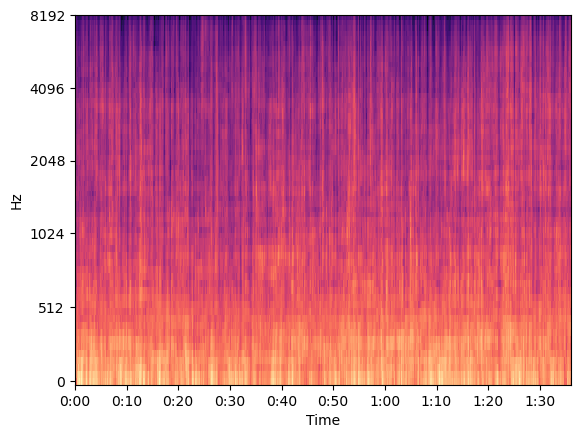

In [39]:
librosa.display.specshow(test_audio_decode.sample[0].detach().cpu().numpy()[0], x_axis="time", y_axis="mel", sr=16000)

In [40]:
audio_vocod_perm = pipe.mel_spectrogram_to_waveform(test_audio_decode.sample.permute(0,1,3,2)).to(device)
# audio_vocod = pipe.mel_spectrogram_to_waveform(out)

In [41]:
audio_vocod = audio_vocod_perm.detach().cpu().numpy()

In [42]:
audio_vocod.shape

(4, 480032)

In [43]:
audio_vocod = audio_vocod[:,:480000]

In [44]:
from IPython.display import Audio

In [45]:
Audio(audio_vocod[0], rate=16000)

In [46]:
test_filename

['pop.00032',
 'rock.00032',
 'country.00085',
 'blues.00017',
 'disco.00075',
 'metal.00039',
 'reggae.00033',
 'classical.00045',
 'hiphop.00095',
 'jazz.00044',
 'pop.00032',
 'rock.00032',
 'country.00085',
 'blues.00017',
 'disco.00075',
 'metal.00039',
 'reggae.00033',
 'classical.00045',
 'hiphop.00095',
 'jazz.00044',
 'pop.00032',
 'rock.00032',
 'country.00085',
 'blues.00017',
 'disco.00075',
 'metal.00039',
 'reggae.00033',
 'classical.00045',
 'hiphop.00095',
 'jazz.00044',
 'pop.00032',
 'rock.00032',
 'country.00085',
 'blues.00017',
 'disco.00075',
 'metal.00039',
 'reggae.00033',
 'classical.00045',
 'hiphop.00095',
 'jazz.00044',
 'pop.00032',
 'jazz.00014',
 'hiphop.00049',
 'blues.00073',
 'rock.00066',
 'country.00007',
 'pop.00066',
 'disco.00000',
 'classical.00008',
 'metal.00064',
 'reggae.00070',
 'jazz.00014',
 'hiphop.00049',
 'blues.00073',
 'rock.00066',
 'country.00007',
 'pop.00066',
 'disco.00000',
 'classical.00008',
 'metal.00064',
 'reggae.00070',
 '

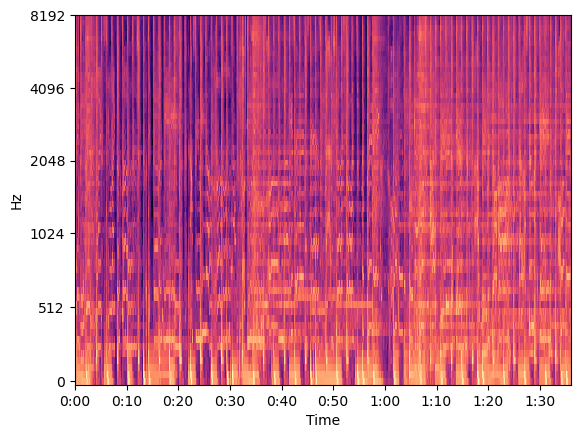

In [49]:
path_pop = '/data01/data/fMRI_music_genre/data_wav/genres_original/pop/pop.00032.wav'
audio_pop, _, _, _, _ = read_audio_file(path_pop)
librosa.display.specshow(audio_pop.T.detach().numpy(), x_axis="time", y_axis="mel", sr=16000)

In [50]:
audio_pop.shape

torch.Size([3000, 64])

In [48]:
Audio(path_pop)